Importing libraries

In [ ]:
import numpy as np
import pandas as pd
import random as rn

In [ ]:
# tensorflow
import tensorflow.random as tfr
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPool2D, MaxPooling2D, BatchNormalization
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [ ]:
# Chart
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [ ]:
import seaborn as sns
import glob

from skimage import color, exposure
from sklearn.metrics import classification_report

import os
import cv2

In [ ]:
# Setting the same seed for repeatability

seed = 0

np.random.seed(seed)
rn.seed(seed)
tfr.set_seed(seed)

# Display graphs inline
%matplotlib inline

Reading data

In [ ]:
data_path = '/content/drive/MyDrive/archive/chest_xray/chest_xray/'

train_path = data_path + 'train/'
test_path = data_path + 'test/'
val_path = data_path + 'val/'

In [ ]:
img_size = 200

In [ ]:
def read_data(data_paths):
    for data_path in data_paths:
        labels = ['PNEUMONIA', 'NORMAL']
        images = []
        y = []
        for label in labels:
            curr_path = data_path + label
            for img in os.listdir(curr_path):
                if ('DS' not in img):
                    image_path = os.path.join(curr_path, img)
                    image =  cv2.resize(cv2.imread(image_path), (img_size, img_size))
                    if image is not None:
                        images.append([image, label])

    images = np.asarray(images, dtype=object)
    return images

In [ ]:
train = read_data([train_path])
test = read_data([val_path, test_path])

for i in range(10):
    np.random.shuffle(train)
    np.random.shuffle(test)

In [ ]:
train_df = pd.DataFrame(train, columns=['image', 'label'])
test_df = pd.DataFrame(test, columns = ['image', 'label'])

In [ ]:
train_df['label'].head()

0    PNEUMONIA
1    PNEUMONIA
2    PNEUMONIA
3    PNEUMONIA
4    PNEUMONIA
Name: label, dtype: object

Exploratory Data Analysis

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


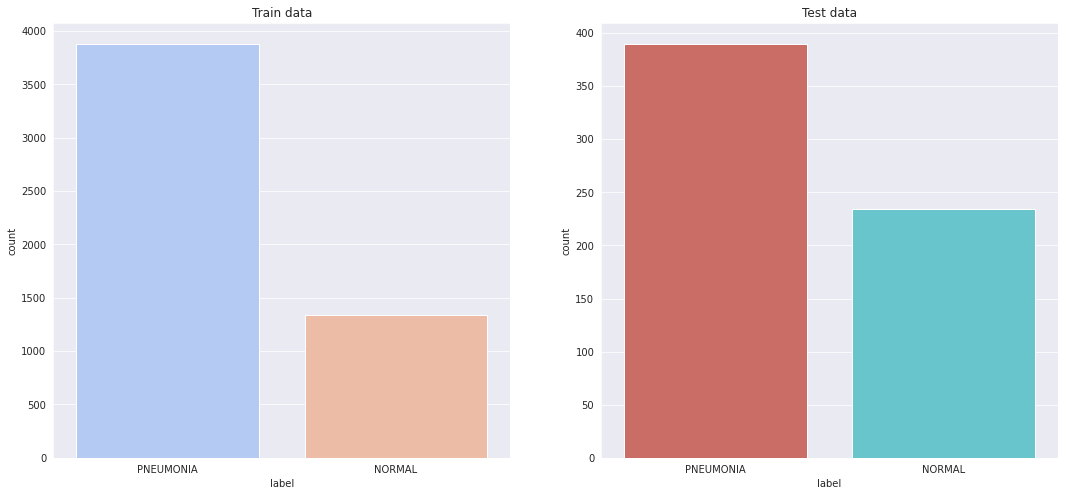

In [ ]:
plt.figure(figsize=(18, 8))
sns.set_style("darkgrid")

plt.subplot(1,2,1)
sns.countplot(train_df['label'], palette = 'coolwarm')
plt.title('Train data')

plt.subplot(1,2,2)
sns.countplot(test_df['label'], palette = "hls")
plt.title('Test data')

plt.show()

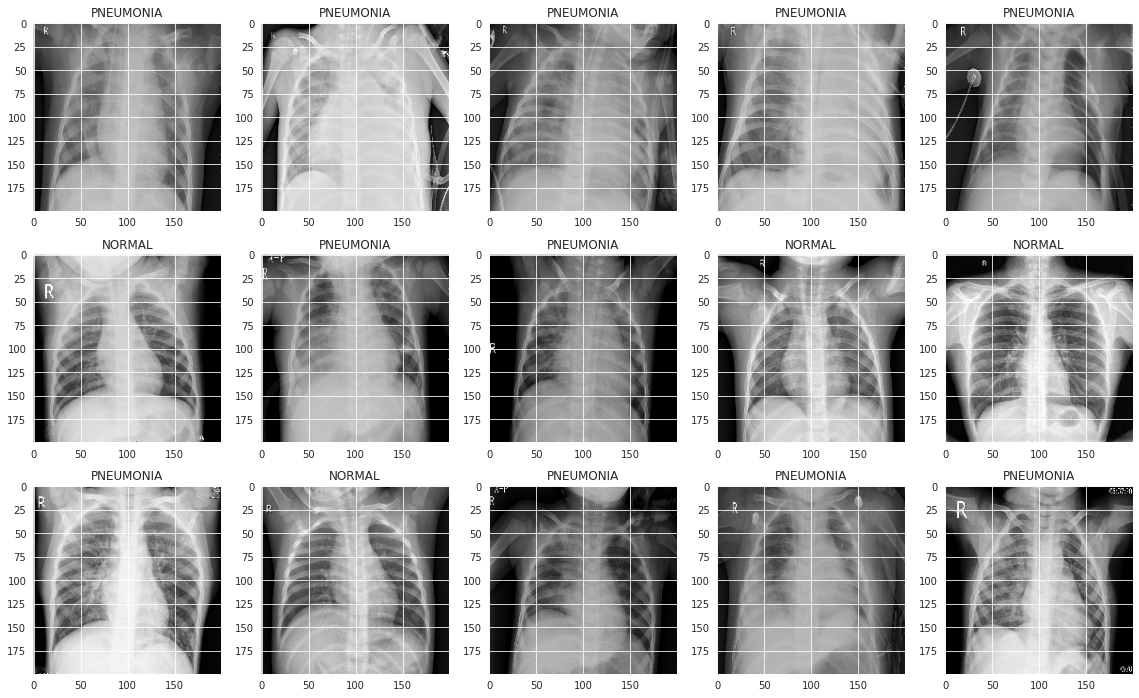

In [ ]:
def Show_example_image():
    fig = plt.figure(figsize = (16, 16))
    for idx in range(15):
        plt.subplot(5, 5, idx+1)
        plt.imshow(train_df.iloc[idx]['image'])
        plt.title("{}".format(train_df.iloc[idx]['label']))

    plt.tight_layout()

Show_example_image()

Data preprocessing

In [ ]:
def lung_condition(label):
    if label == 'NORMAL':
        return 0
    else:
        return 1

In [ ]:
# split data
def splitdata(data):
    X = []
    y = []
    for i, (val, label) in enumerate(data):
        X.append(val)
        y.append(lung_condition(label))
    return np.array(X), np.array(y)

In [ ]:
np.random.shuffle(train)
np.random.shuffle(test)
X_train, y_train = splitdata(train)
X_test, y_test = splitdata(test)

In [ ]:
def preprocesing_to_cnn(data):
    data1 = color.rgb2gray(data).reshape(-1, img_size, img_size, 1).astype('float32')
    data1 /= 255
    return data1

In [ ]:
X_train = preprocesing_to_cnn(X_train)
X_test = preprocesing_to_cnn(X_test)

# one-hot encoding for target column
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [ ]:
num_classes = y_train.shape[1]
input_shape = (img_size, img_size, 1)

In [ ]:
datagen = ImageDataGenerator(
        featurewise_center = False,
        samplewise_center = False,
        featurewise_std_normalization = False,
        samplewise_std_normalization = False,
        zca_whitening = False,
        horizontal_flip = False,
        vertical_flip = False,
        rotation_range = 10,
        zoom_range = 0.1,
        width_shift_range = 0.1,
        height_shift_range = 0.1)

datagen.fit(X_train)
train_gen = datagen.flow(X_train, y_train, batch_size = 32)

In [ ]:
callbacks4 = [
    EarlyStopping(monitor = 'loss', patience = 7),
    ReduceLROnPlateau(monitor = 'loss', patience = 4),
    ModelCheckpoint('../working/model.best4.hdf5', monitor='loss' , save_best_only=True) # saving the best model
]

First model CNN

In [ ]:
def get_modelcnn_v2():
    return Sequential([
        Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same', input_shape = input_shape),
        Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.2),

        Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'),
        Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.2),

        Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
        Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.2),

        Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),
        Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.2),

        Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'),
        Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.2),

        Flatten(),

        Dense(1024, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),

        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.4),

        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),

        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),

        Dense(num_classes, activation = "softmax")

    ])


In [ ]:
model = get_modelcnn_v2()
model.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 200, 200, 16)      160       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 200, 200, 16)      2320      
_________________________________________________________________
batch_normalization (BatchNo (None, 200, 200, 16)      64        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 100, 100, 16)      0         
_________________________________________________________________
dropout (Dropout)            (None, 100, 100, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 100, 100, 32)      4640      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 100, 100, 32)      9

Fitting the model

In [ ]:
learning_history = model.fit_generator((train_gen),
                               epochs = 60,
                               steps_per_epoch = X_train.shape[0] // 32,
                               validation_data = (X_test, y_test),
                               callbacks = callbacks4,
                        )

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
163/163 [==============================] - 27s 111ms/step - loss: 0.7328 - accuracy: 0.6826 - val_loss: 3.1392 - val_accuracy: 0.6250
Epoch 2/100
163/163 [==============================] - 18s 108ms/step - loss: 0.3480 - accuracy: 0.8565 - val_loss: 1.7463 - val_accuracy: 0.6250
Epoch 3/100
163/163 [==============================] - 18s 109ms/step - loss: 0.2694 - accuracy: 0.8962 - val_loss: 1.5448 - val_accuracy: 0.6250
Epoch 4/100
163/163 [==============================] - 18s 109ms/step - loss: 0.1989 - accuracy: 0.9219 - val_loss: 0.8531 - val_accuracy: 0.5994
Epoch 5/100
163/163 [==============================] - 18s 109ms/step - loss: 0.2090 - accuracy: 0.9234 - val_loss: 2.0568 - val_accuracy: 0.6282
Epoch 6/100
163/163 [==============================] - 18s 110ms/step - loss: 0.1741 - accuracy: 0.9343 - val_loss: 2.6380 - val_accuracy: 0.6250
Epoch 7/100
163/163 [==============================] - 18s 110ms/step - loss: 0.1573 - accuracy: 0.9418 - val_loss: 4.1022 -

Evaluating model

In [ ]:
score = model.evaluate(X_test, y_test, verbose = 0)
print('Test loss: {}%'.format(score[0] * 100))
print('Test accuracy: {}%'.format(score[1] * 100))


Test loss: 20.969749987125397%
Test accuracy: 91.98718070983887%
